<a href="https://colab.research.google.com/github/Marin-kh/price-prediction/blob/main/preprocessing_properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install basemap
!pip install osmnx
!pip install xgboost
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.4/942.4 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 62.1 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.1
    Uninstalling pyproj-3.7.1:
      Successfully uninstalled pyproj-3.7.1
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from scipy.stats import zscore
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import re
import requests
import xml.etree.ElementTree as ET

In [ ]:
# pd.set_option('display.float_format', '{:.0f}'.format)

In [4]:
drive.mount('/content/drive')
subpath ='/content/drive/My Drive/price-prediction'
df = pd.read_csv(f'{subpath}/delta_data/2024_Tehran_House_Price.csv')
df_region = pd.read_csv(f'{subpath}/delta_data/regions_updated.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df['Age'] = df['Age'].astype('int')
df['Price'] = (df['Price']/10).astype('int')
df['Meter'] = df['Meter'].astype('int')
df['Loan'] = df['Loan'].astype('int')
df['Parking'] = df['Parking'].astype('int')
df['Elevator'] = df['Elevator'].astype('int')
df['WareHouse'] = df['WareHouse'].astype('int')
df['Rooms'] = df['Rooms'].astype('int')
df['Floor'] = df['Floor'].astype('int')
df['validDate'] = pd.to_datetime(df['validDate'])

df['DaysSinceRegistration'] = (datetime.now() - df['validDate']).dt.days.astype('int')

rows_to_delete = df[df['Region'].isin(df_region['name']) & ~df['City'].str.contains('تهران')]
df = df[~df.index.isin(rows_to_delete.index)]

rows_to_delete = df[~df['Region'].isin(df_region['name'])]
df = df[~df.index.isin(rows_to_delete.index)]

# # if 0 --> region fixed
# print(len(df[~df['Region'].isin(df_region['name'])]))

# Delete Pre-sale
df['Title'] = df['Title'].fillna('')

df = df[~df['Title'].str.contains('پیش فروش')]
df = df[~df['Title'].str.contains('پیش خرید')]
df = df[~df['Title'].str.contains('پیش پرداخت')]
df = df[~df['Title'].str.contains('در حال ساخت')]
df = df[~df['Title'].str.contains('اقساط')]
df = df[~df['Title'].str.contains('سرمایه گذاری')]
df = df[~df['Title'].str.contains('سهام')]
df = df[~df['Title'].str.contains('پروژه')]
df = df[~df['Title'].str.contains('معاوضه')]
df = df[~df['Title'].str.contains('تهاتر')]
df = df[~df['Title'].str.contains('وام')]

df = df.drop(['Title'], axis=1)

df['per_meter'] = (df['Price']/df['Meter']).astype('int')
df = df.where(df['per_meter']>25000000).dropna()
df = df.where(df['per_meter']<800000000).dropna()

# Divar
rows_to_delete = df[df['City'] == ('تهران منطقه 21 و 22')]
df = df[~df.index.isin(rows_to_delete.index)]

# Fake data
df = df.where(df['Meter']>30).dropna()
df = df.where(df['Meter']>30).dropna()


df['P'] = df['Price'].astype(str).str.split('.').str[0].str[-3:].astype(int)
df['Price'] = df['Price'].astype('int')
df = df.where(df['P']==0).dropna()
df = df.drop(['P'], axis=1)

df = df[df['Price']>1000000000]

def fill_lat_lon(x):
  if x['Latitude']==0:
      x['Latitude'] = x['lat']
  if x['Longitude']==0:
      x['Longitude'] = x['long']
  return x

df = df.merge(df_region[['name', 'lat', 'long']], left_on='Region', right_on='name', how='left')
df = df.apply(fill_lat_lon, 1)
df = df.drop(columns=['name', 'lat', 'long'])

average_price_by_region = df.groupby('Region')['per_meter'].mean().reset_index()
average_price_by_region = average_price_by_region.rename(columns={'per_meter': 'Average_per_meter'})

df_region = df_region.merge(
    average_price_by_region,
    left_on='name',
    right_on='Region',
    how='left'
)

df_region = df_region.drop(columns=['Region'])
df_region = df_region.dropna()
df_region['Average_per_meter'] = df_region['Average_per_meter'].astype('int')

df = pd.merge(
    df,
    df_region,
    left_on='Region',
    right_on='name',
    how='left'
)

df.drop(columns=['name', 'id', 'link', 'lat', 'long'], inplace=True)

df = df.drop(['Category',	'PropertyTypes', 'Address', 'City',	'Region', 'validDate'], axis=1)

df_encoded = df

upper_cap_95 = df_encoded['Price'].quantile(0.95)
upper_cap_99 = df_encoded['Price'].quantile(0.99)

df_encoded['Price_capped_95'] = df_encoded['Price'].clip(upper=upper_cap_95)
df_encoded['Price_avg'] = (df_encoded['Price'] + df_encoded['Price_capped_95']) / 2

df_encoded['Price_capped'] = df_encoded['Price_avg'].clip(upper=upper_cap_99)
df_encoded['Price_capped'] = df_encoded['Price_capped'].astype('int')
print(df_encoded[['Price','Price_capped', 'Meter', 'Age', 'Rooms', 'Floor']][df_encoded['Price'] > upper_cap_99])

df_encoded = df_encoded.drop(['Price_capped_95', 'Price_avg'], axis=1)

df_encoded = df_encoded.drop(['Latitude', 'Longitude', 'per_meter'], axis=1)\

df_encoded['Age'] = df_encoded['Age'].astype('int')
df_encoded['Price'] = (df_encoded['Price']).astype('int')
df_encoded['Meter'] = df_encoded['Meter'].astype('int')
df_encoded['Loan'] = df_encoded['Loan'].astype('int')
df_encoded['Parking'] = df_encoded['Parking'].astype('int')
df_encoded['Elevator'] = df_encoded['Elevator'].astype('int')
df_encoded['WareHouse'] = df_encoded['WareHouse'].astype('int')
df_encoded['Rooms'] = df_encoded['Rooms'].astype('int')
df_encoded['Floor'] = df_encoded['Floor'].astype('int')
df_encoded['DaysSinceRegistration'] = df_encoded['DaysSinceRegistration'].astype('int')

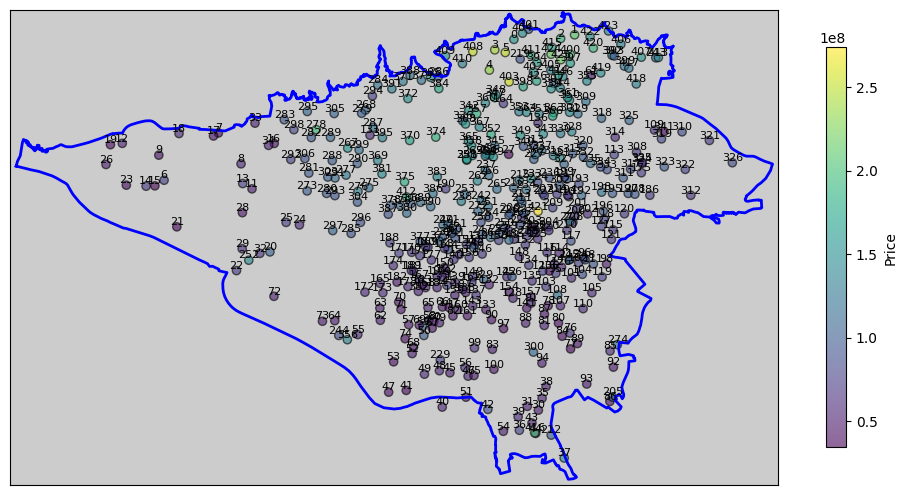

In [ ]:
from mpl_toolkits.basemap import Basemap
import osmnx as ox

def map(lo1, la1, lo2, la2):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    m = Basemap(llcrnrlon=lo1, llcrnrlat=la1,urcrnrlon=lo2,urcrnrlat=la2,
                rsphere=(6378137.00, 6356752.3142),
                resolution='l', projection='merc',
                lat_0=40., lon_0=-20., lat_ts=20.)

    m.drawcoastlines()
    m.fillcontinents()

    x, y = m(df_region['long'], df_region['lat'])
    scatter = plt.scatter(x, y, c=df_region['Average_per_meter'], cmap='viridis', alpha=0.6, edgecolor='k')

    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', label='Price', shrink=0.5)

    # Show Id!
    for i, txt in enumerate(df_region['id']):
        ax.annotate(txt, (x[i], y[i]), fontsize=8, ha='center', va='bottom')

    tehranshape = ox.geocode_to_gdf('Tehran, Iran')

    for geometry in tehranshape.geometry:
        if geometry.geom_type == 'Polygon':
            x, y = m(geometry.exterior.xy[0], geometry.exterior.xy[1])
            m.plot(x, y, color='blue', linewidth=2, ax=ax)
        elif geometry.geom_type == 'MultiPolygon':
            for polygon in geometry:
                x, y = m(polygon.exterior.xy[0], polygon.exterior.xy[1])
                m.plot(x, y, color='blue', linewidth=2, ax=ax)

    m.drawparallels(np.arange(20, 50, 10), labels=[1, 1, 0, 1])
    m.drawmeridians(np.arange(40, 80, 10), labels=[1, 1, 0, 1])
    ax.set_aspect('equal')
    plt.show()

df_region['id']= np.arange(len(df_region))
df_region = df_region.reset_index(drop=True)
map(51.085,35.565,51.61,35.83)


Fuad

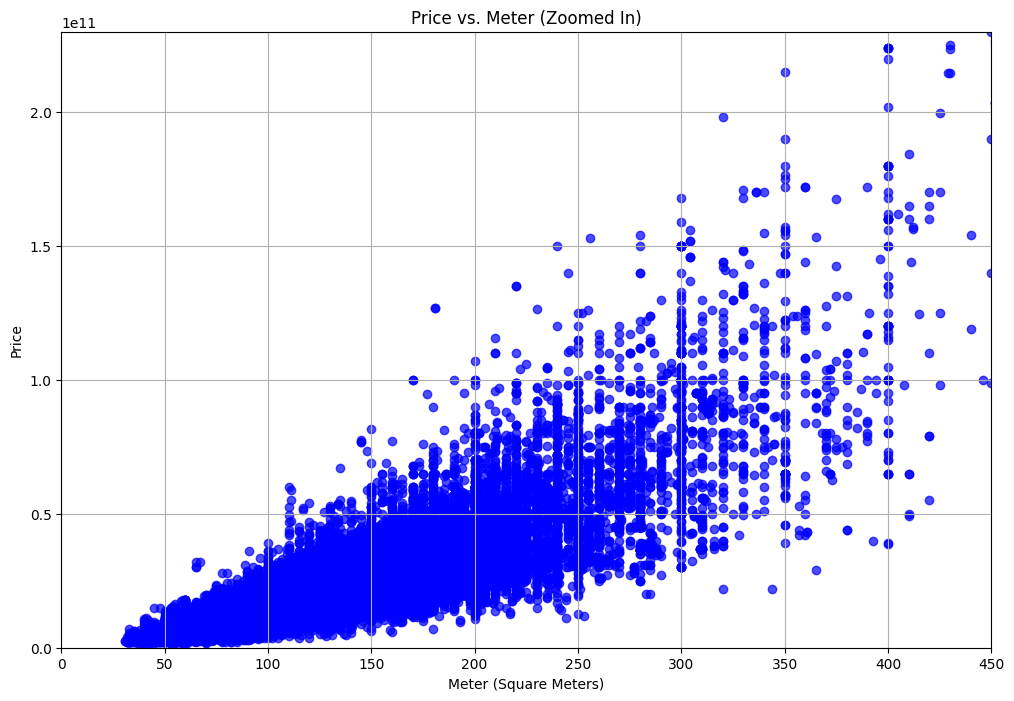

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(df['Meter'], df['Price'], alpha=0.7, color='blue')

plt.xlim(0, 450)
plt.ylim(0, 230000000000)
# plt.xlim(180, 260)
# plt.ylim(6400000000, 8600000000)


plt.xlabel('Meter (Square Meters)')
plt.ylabel('Price')
plt.title('Price vs. Meter (Zoomed In)')

plt.grid(True)
plt.show()

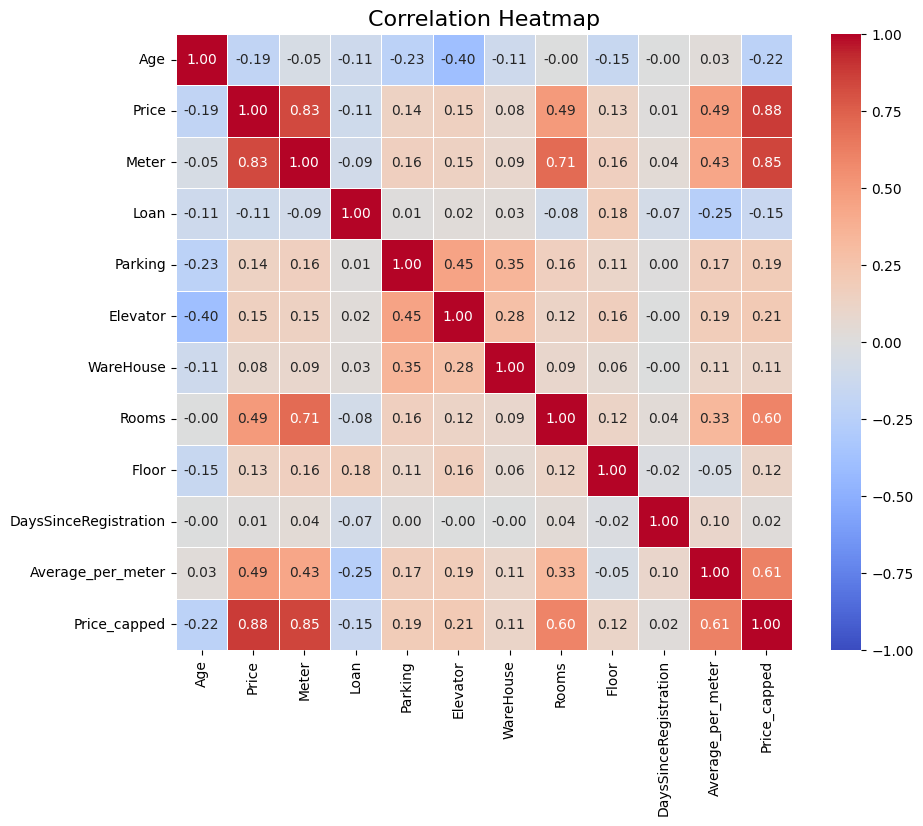

In [ ]:
corr_matrix = df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True
)

plt.title("Correlation Heatmap", fontsize=16)

plt.show()

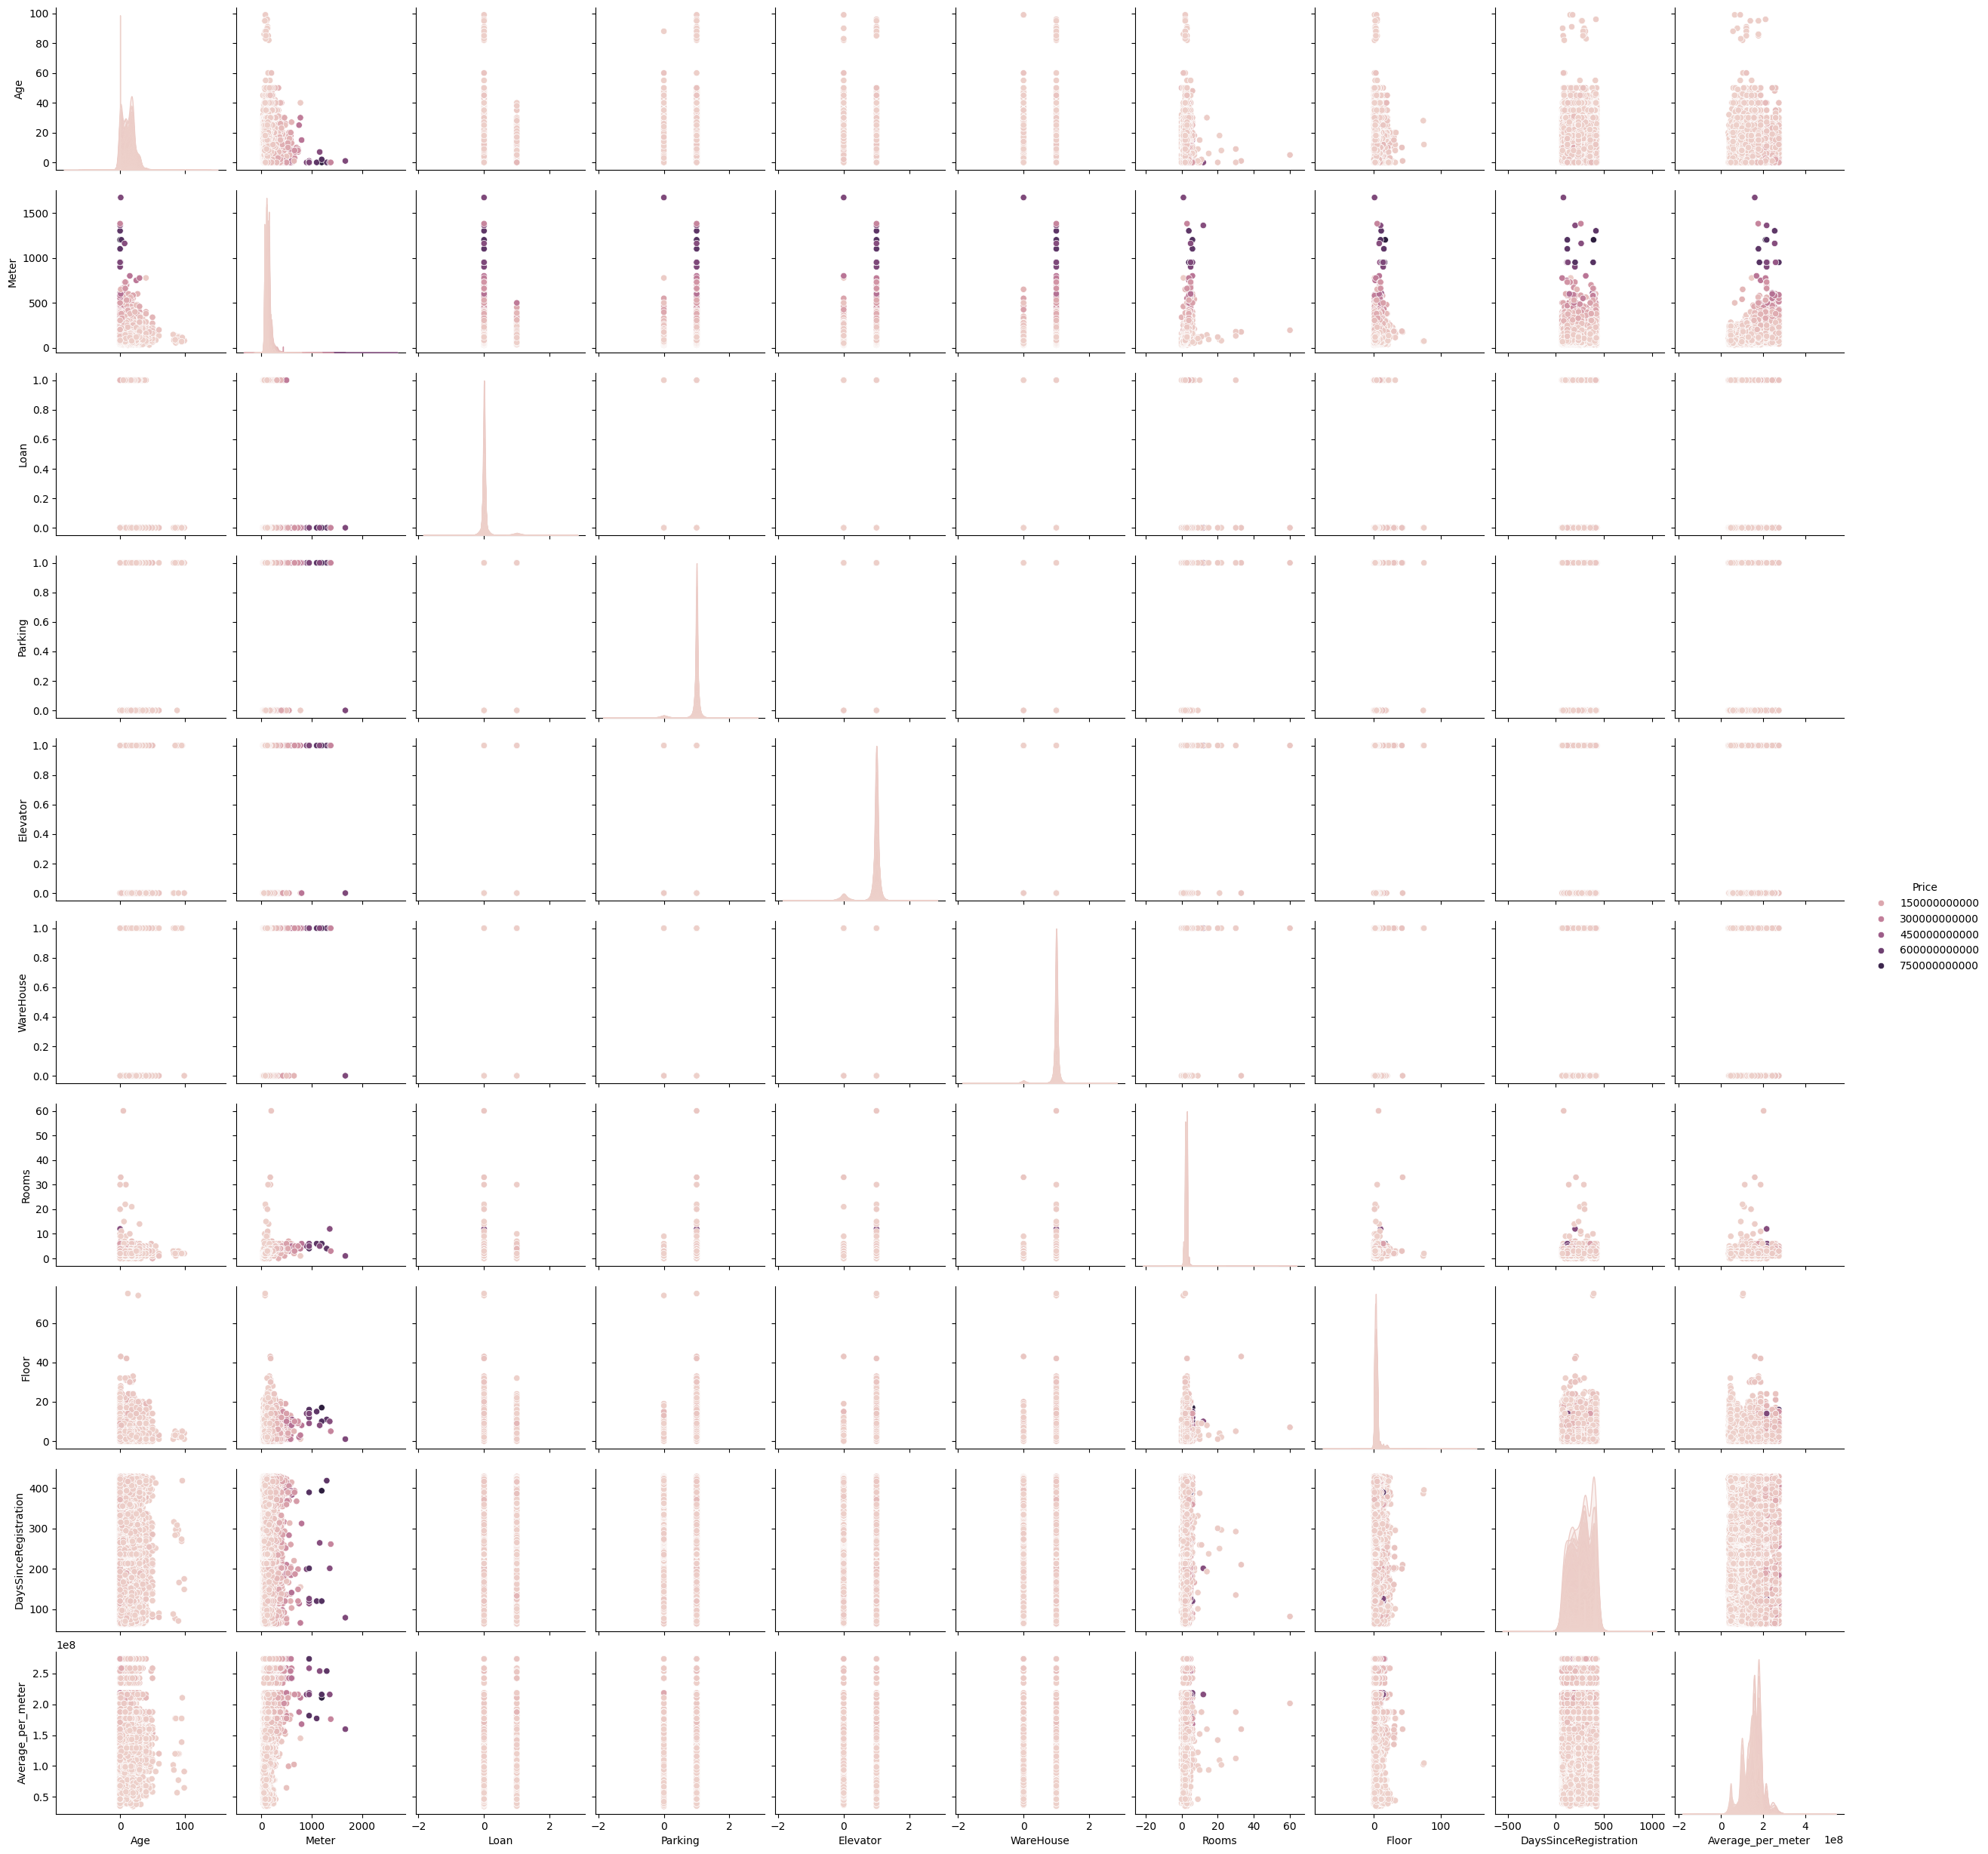

In [ ]:
sns.pairplot(df_encoded.drop(columns=['Price_capped']), hue='Price')

--------------------------------------------------------------------------------------------------------------------
#TRAIN & TEST

In [27]:
def result(y_pred, y_real):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_real, y_pred, alpha=0.7, color='blue', label='Predictions')
    plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs. Predicted Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

    mse = mean_squared_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R2):", r2)

In [28]:
from sklearn.preprocessing import RobustScaler

X = df_encoded.drop(['Price', 'Price_capped'], axis=1)
y = df_encoded['Price']
y2 = df_encoded['Price_capped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=42)

continuous_features = ['Age', 'Meter', 'DaysSinceRegistration', 'Average_per_meter']

scaler = RobustScaler()
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

scaler2 = RobustScaler()
X_train2[continuous_features] = scaler2.fit_transform(X_train2[continuous_features])
X_test2[continuous_features] = scaler2.transform(X_test2[continuous_features])

In [ ]:
# Linear Regression

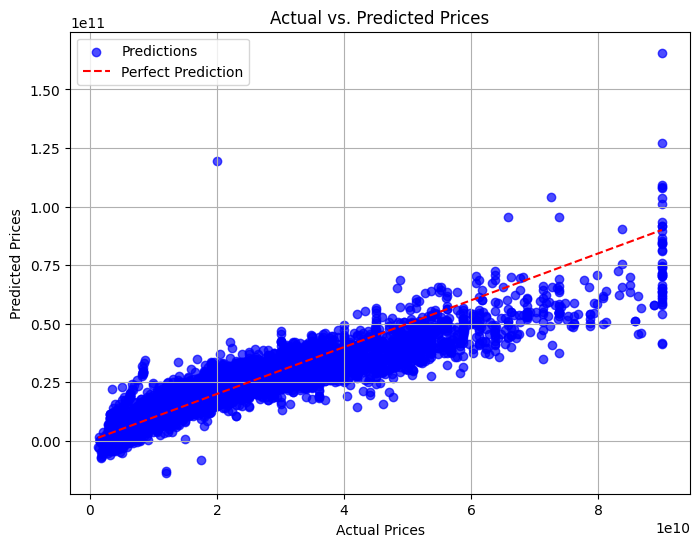

Mean Squared Error (MSE): 2.775795968639433e+19
R-squared (R2): 0.8403043334570719


In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

result(y_pred_lr, y_test)

In [ ]:
# Polynomial Regression

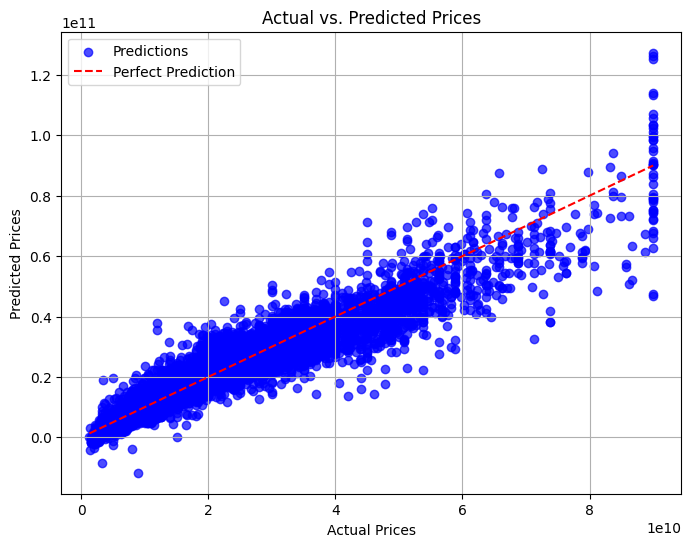

Mean Squared Error (MSE): 1.9339302292754477e+19
R-squared (R2): 0.8887381203442558


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 2
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X_train, y_train)

y_pred_poly = poly_model.predict(X_test)

result(y_pred_poly, y_test)

In [ ]:
# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

param_grid = {
    'n_estimators': [80, 100, 150],
    'max_depth': [20, 30, 40, None],
    'min_samples_split': [5, 8, 10]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


best_rf_model = grid_search.best_estimator_
y_pred_rf_best = best_rf_model.predict(X_test)

result(y_pred_rf_best, y_test)

KeyboardInterrupt: 

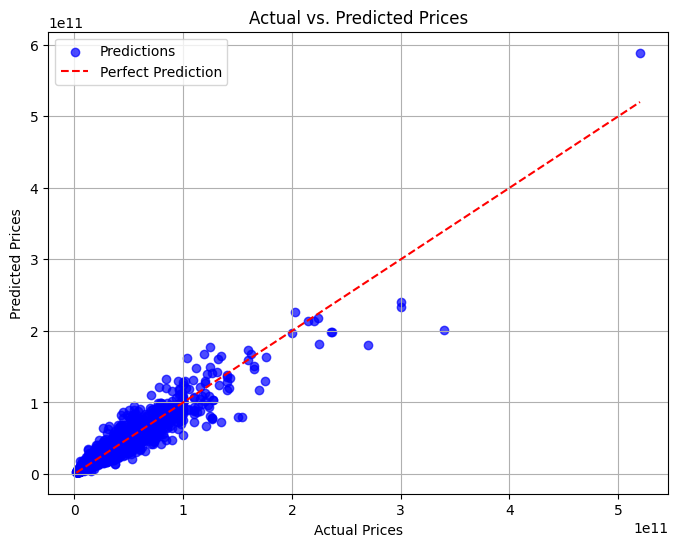

Mean Squared Error (MSE): 2.3909421022832185e+19
R-squared (R2): 0.9227627429054783


In [ ]:
from sklearn.ensemble import RandomForestRegressor


rf_model = RandomForestRegressor(max_depth= 20, min_samples_split= 5, n_estimators= 80)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

result(y_pred_rf, y_test)

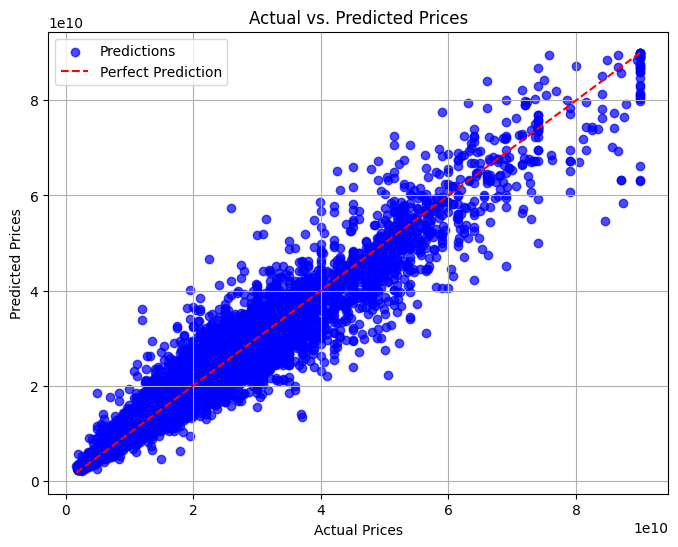

Mean Squared Error (MSE): 1.118638589169918e+19
R-squared (R2): 0.9349306021585267


In [ ]:
from sklearn.ensemble import RandomForestRegressor


rf_model2 = RandomForestRegressor(max_depth= 20, min_samples_split= 5, n_estimators= 80)

rf_model2.fit(X_train2, y_train2)

y_pred_rf2 = rf_model2.predict(X_test2)

result(y_pred_rf2, y_test2)

In [ ]:
print(rf_model.get_params())

feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 80, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
                 Feature  Importance
1                  Meter    0.821888
0                    Age    0.068037
9      Average_per_meter    0.066383
8  DaysSinceRegistration    0.020215
7                  Floor    0.017007
6                  Rooms    0.004121
4               Elevator    0.000944
2                   Loan    0.000547
3                Parking    0.000541
5              WareHouse    0.000317


In [ ]:
print(rf_model2.get_params())

feature_importances2 = rf_model2.feature_importances_
feature_names2 = X_train2.columns

importance_df2 = pd.DataFrame({
    'Feature': feature_names2,
    'Importance': feature_importances2
}).sort_values(by='Importance', ascending=False)

print(importance_df2)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 80, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
                 Feature  Importance
1                  Meter    0.776963
9      Average_per_meter    0.106472
0                    Age    0.074341
8  DaysSinceRegistration    0.022151
7                  Floor    0.013785
6                  Rooms    0.002787
4               Elevator    0.001956
3                Parking    0.000743
2                   Loan    0.000463
5              WareHouse    0.000338


In [ ]:
mahale = 'شهرزیبا'
per_meter = df_region[df_region['name'] == mahale]['Average_per_meter'].values[0]
lat = df_region[df_region['name'] == mahale]['lat'].values[0]
lon = df_region[df_region['name'] == mahale]['long'].values[0]
print(f"per meter(region): {(per_meter/ 1_000_000):.2f} million Tomans")

input_data = {
'Age': [30],
'Meter': [100],
'DaysSinceRegistration': [30],
'Average_per_meter': [per_meter],
'Loan': [0],
'Parking': [1],
'Elevator': [0],
'WareHouse': [1],
'Rooms': [3],
'Floor': [1]
}
input_df = pd.DataFrame(input_data)

continuous_features = ['Age', 'Meter', 'DaysSinceRegistration', 'Average_per_meter']
scaler = StandardScaler()
input_df[continuous_features] = scaler.fit_transform(input_df[continuous_features])

input_df = input_df[X_train.columns]

# scaler.fit(X_train[continuous_features])
# input_df[continuous_features] = scaler.transform(input_df[continuous_features])
# input_df = input_df[X_train.columns]

per meter(region): 93.34 million Tomans


In [ ]:
prediction = rf_model.predict(input_df)
prediction_billions = prediction[0] / 1_000_000_000
print(f"Predicted value: {prediction_billions:.2f} billion Tomans")

Predicted value: 2.95 billion Tomans


In [ ]:
prediction2 = rf_model2.predict(input_df)
prediction_billions2 = prediction2[0] / 1_000_000_000
print(f"Predicted value: {prediction_billions2:.2f} billion Tomans")

Predicted value: 2.94 billion Tomans


In [ ]:
# XGBoost

In [29]:
import xgboost as xgb
dtrain = xgb.DMatrix([[1, 2], [3, 4]], label=[0, 1])
params = {
"tree_method": "gpu_hist",
}
try:
  bst = xgb.train(params, dtrain, num_boost_round=1)
  print("GPU is working with XGBoost!")
except xgb.core.XGBoostError as e:
  print("GPU is NOT working with XGBoost:", e)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:19:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


GPU is working with XGBoost!


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

xgb_model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)

param_grid = {
'n_estimators': [100, 200, 300],
'max_depth': [3, 5, 10],
'learning_rate': [0.01, 0.1, 0.2],
'subsample': [0.8, 0.9, 1.0],
'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters (XGBoost):", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_
y_pred_xgb_best = best_xgb_model.predict(X_test)

Best Parameters (XGBoost): {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:55:00] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:55:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:55:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:19:46] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:19:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


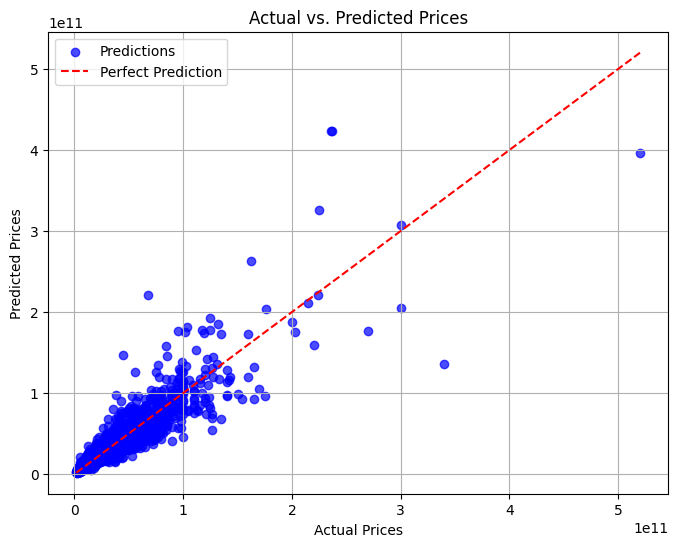

Mean Squared Error (MSE): 4.509817145723244e+19
R-squared (R2): 0.8543143272399902


In [30]:
from xgboost import XGBRegressor
# tree_method='gpu_hist'
xgb_model = XGBRegressor( gpu_id=0, colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
result(y_pred_xgb, y_test)

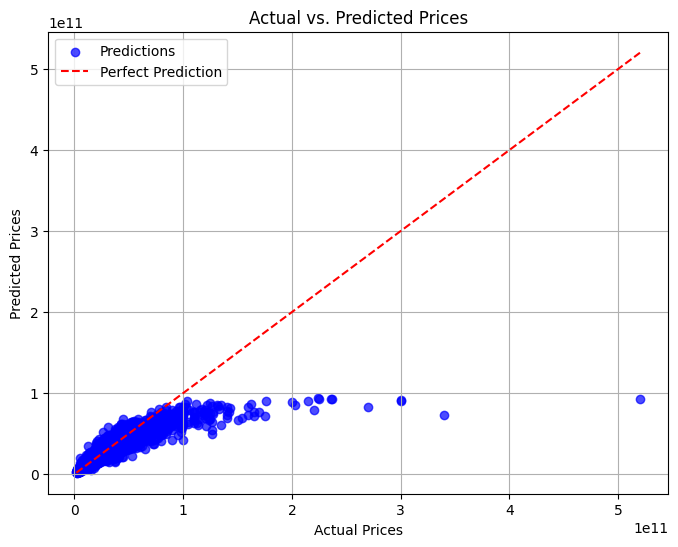

Mean Squared Error (MSE): 7.445727376750254e+19
R-squared (R2): 0.7594724297523499


In [31]:
from xgboost import XGBRegressor
# tree_method='gpu_hist',
xgb_model2 = XGBRegressor( gpu_id=0, colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0)
xgb_model2.fit(X_train, y_train2)

y_pred_xgb2 = xgb_model2.predict(X_test)
result(y_pred_xgb2, y_test)

In [55]:
prediction = xgb_model2.predict(input_df2)
prediction_billions = prediction[0] / 1_000_000_000
print(f"Predicted value: {prediction_billions:.2f} billion Tomans")

Predicted value: 51.30 billion Tomans


In [56]:
from xgboost import XGBRegressor

scaler = RobustScaler()
X[continuous_features] = scaler.fit_transform(X[continuous_features])

xgb_model2 = XGBRegressor( gpu_id=0, colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0)
xgb_model2.fit(X, y2)

y_pred_xgb2 = xgb_model2.predict(X)

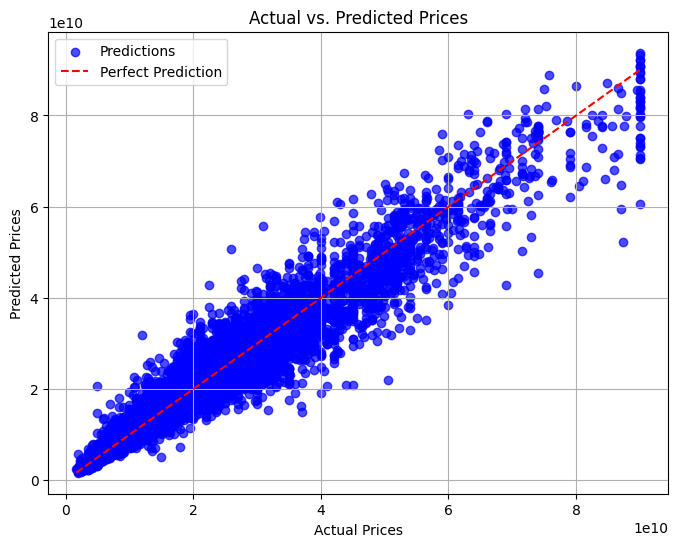

Mean Squared Error (MSE): 1.2494559482410078e+19
R-squared (R2): 0.9273211679191053


In [57]:
X_layer2 = pd.DataFrame({
    'Meter': X['Meter'],
    'xgb_pred2': y_pred_xgb2
})

X_train, X_test, y_train, y_test = train_test_split(X_layer2, y2, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

result(y_pred_lr, y_test)

In [109]:
mahale = 'نبرد'
per_meter = df_region[df_region['name'] == mahale]['Average_per_meter'].values[0]
lat = df_region[df_region['name'] == mahale]['lat'].values[0]
lon = df_region[df_region['name'] == mahale]['long'].values[0]
print(f"per meter(region): {(per_meter/ 1_000_000):.2f} million Tomans")


input_data = {
'Age': [1],
'Meter': [45],
'DaysSinceRegistration': [1],
'Average_per_meter': [per_meter],
'Loan': [0],
'Parking': [0],
'Elevator': [1],
'WareHouse': [0],
'Rooms': [1],
'Floor': [1]
}

input_df = pd.DataFrame(input_data)

continuous_features = ['Age', 'Meter', 'DaysSinceRegistration', 'Average_per_meter']

input_df[continuous_features] = scaler.transform(input_df[continuous_features])
input_df = input_df[X.columns]
print(input_df,'\n')

prediction = xgb_model2.predict(input_df)
prediction_billions = prediction[0] / 1_000_000_000
print(f"Predicted value1: {prediction_billions:.2f} billion Tomans")

X_tt = pd.DataFrame({
    'Meter': input_df['Meter'],
    'xgb_pred2': prediction
})
prediction2 = lr_model.predict(X_tt)
prediction_billions2 = prediction2[0] / 1_000_000_000
print(f"Predicted value2: {prediction_billions2:.2f} billion Tomans")

per meter(region): 73.48 million Tomans
   Age     Meter  Loan  Parking  Elevator  WareHouse  Rooms  Floor  \
0 -0.6 -1.145161     0        0         1          0      1      1   

   DaysSinceRegistration  Average_per_meter  
0              -1.356784          -1.661025   

Predicted value1: 3.76 billion Tomans
Predicted value2: 3.70 billion Tomans


per meter(region): 67.24 million Tomans


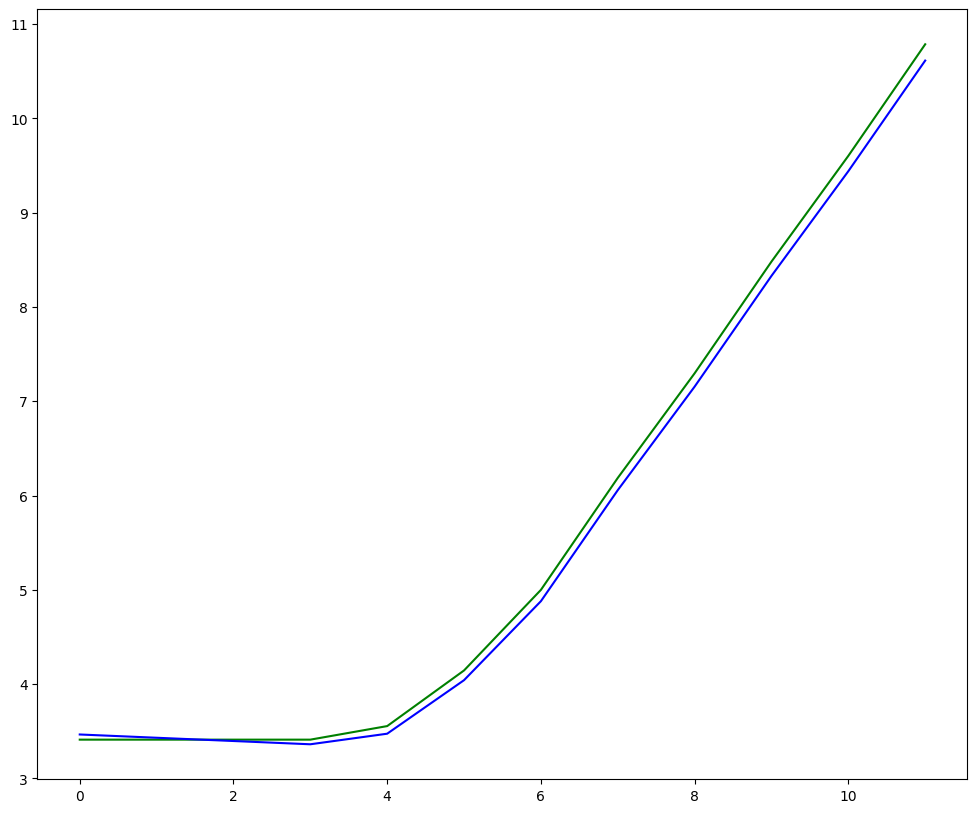

In [99]:
mahale = 'پیروزی'
per_meter = df_region[df_region['name'] == mahale]['Average_per_meter'].values[0]
lat = df_region[df_region['name'] == mahale]['lat'].values[0]
lon = df_region[df_region['name'] == mahale]['long'].values[0]
print(f"per meter(region): {(per_meter/ 1_000_000):.2f} million Tomans")

a=[]
b=[]
items = [10,20,30,40,50, 60,70,80,90,100,110,120]
for i in items:
    input_data = {

    'Age': [1],
    'Meter': [i],
    'DaysSinceRegistration': [1],
    'Average_per_meter': [per_meter],
    'Loan': [0],
    'Parking': [0],
    'Elevator': [1],
    'WareHouse': [0],
    'Rooms': [1],
    'Floor': [1]
    }

    input_df = pd.DataFrame(input_data)

    continuous_features = ['Age', 'Meter', 'DaysSinceRegistration', 'Average_per_meter']

    input_df[continuous_features] = scaler.transform(input_df[continuous_features])
    input_df = input_df[X.columns]

    prediction = xgb_model2.predict(input_df)
    prediction_billions = prediction[0] / 1_000_000_000

    X_tt = pd.DataFrame({
        'Meter': input_df['Meter'],
        'xgb_pred2': prediction
    })
    prediction2 = lr_model.predict(X_tt)
    prediction_billions2 = prediction2[0] / 1_000_000_000
    a.append(prediction_billions)
    b.append(prediction_billions2)

fig = plt.figure(figsize=(12, 10))
plt.plot(a, color='g', label='a')
plt.plot(b, color='b', label='b')
plt.show()

In [53]:
mahale = 'جردن'
per_meter = df_region[df_region['name'] == mahale]['Average_per_meter'].values[0]
lat = df_region[df_region['name'] == mahale]['lat'].values[0]
lon = df_region[df_region['name'] == mahale]['long'].values[0]
print(f"per meter(region): {(per_meter/ 1_000_000):.2f} million Tomans")

input_data = {

'Age': [20],
'Meter': [300],
'DaysSinceRegistration': [1],
'Average_per_meter': [per_meter],
'Loan': [0],
'Parking': [1],
'Elevator': [1],
'WareHouse': [1],
'Rooms': [2],
'Floor': [3]
}

input_df = pd.DataFrame(input_data)
input_df2 = pd.DataFrame(input_data)

continuous_features = ['Age', 'Meter', 'DaysSinceRegistration', 'Average_per_meter']

input_df[continuous_features] = scaler.transform(input_df[continuous_features])
input_df2[continuous_features] = scaler2.transform(input_df2[continuous_features])


input_df = input_df[X_train.columns]
input_df2 = input_df2[X_train.columns]

print(input_df)
print(input_df2)

per meter(region): 159.65 million Tomans
        Age     Meter  Loan  Parking  Elevator  WareHouse  Rooms  Floor  \
0  0.666667  2.967742     0        1         1          1      2      3   

   DaysSinceRegistration  Average_per_meter  
0              -1.356784           0.136449  
        Age     Meter  Loan  Parking  Elevator  WareHouse  Rooms  Floor  \
0  0.666667  2.967742     0        1         1          1      2      3   

   DaysSinceRegistration  Average_per_meter  
0              -1.356784           0.136449  


In [54]:
prediction = xgb_model.predict(input_df)
prediction_billions = prediction[0] / 1_000_000_000
print(f"Predicted value: {prediction_billions:.2f} billion Tomans")

Predicted value: 42.65 billion Tomans


In [ ]:
import gradio as gr
import pandas as pd

def predict_price(Age, Meter, region, Loan, Parking, Elevator, WareHouse, Rooms, Floor):
    per_meter = df_region[df_region['name'] == region]['Average_per_meter'].values[0]
    Parking = 1 if Parking == "Yes" else 0
    Elevator = 1 if Elevator == "Yes" else 0
    Loan = 1 if Loan == "Yes" else 0
    WareHouse = 1 if WareHouse == "Yes" else 0

    input_data = {
        'Age': [Age],
        'Meter': [Meter],
        'DaysSinceRegistration': [1],
        'Average_per_meter': [per_meter],
        'Loan': [Loan],
        'Parking': [Parking],
        'Elevator': [Elevator],
        'WareHouse': [WareHouse],
        'Rooms': [Rooms],
        'Floor': [Floor]
    }

    input_df = pd.DataFrame(input_data)
    continuous_features = ['Age', 'Meter', 'DaysSinceRegistration', 'Average_per_meter']
    scaler = StandardScaler()
    input_df[continuous_features] = scaler.fit_transform(input_df[continuous_features])

    input_df = input_df[X_train.columns]

    prediction = xgb_model.predict(input_df)

    prediction_billions = prediction[0] / 1_000_000_000

    return f"Between {(prediction_billions-1):.2f} & {prediction_billions:.2f} billion Tomans"

inputs = [
    gr.Number(label="Age"),
    gr.Number(label="Meter"),
    gr.Dropdown(choices=df_region['name'].tolist(), label="Region"),
    gr.Radio(choices=["Yes", "No"], label="Loan"),
    gr.Radio(choices=["Yes", "No"], label="Parking"),
    gr.Radio(choices=["Yes", "No"], label="Elevator"),
    gr.Radio(choices=["Yes", "No"], label="WareHouse"),
    gr.Number(label="Rooms"),
    gr.Number(label="Floor")
]

interface = gr.Interface(
    fn=predict_price,
    inputs=inputs,
    outputs=gr.Label(label="Predicted value"),
    title="House Price Prediction",
    description="Enter the details of the property to predict its price in billions of Tomans.",
    allow_flagging="never",
    theme="dark"
)

interface.launch()

/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1108: UserWarning: Cannot load dark. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/dark (Request ID: Root=1-67c96957-5dc4a7f9570c498f6b7e4309;a7db2c86-0c0c-44ec-b1a0-e1827d52989b)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")
/usr/local/lib/python3.11/dist-packages/gradio/interface.py:403: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6d060c35ede3f1d079.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import pandas as pd

def predict_price(Age, Meter, region, Loan, Parking, Elevator, WareHouse, Rooms, Floor):
    per_meter = df_region[df_region['name'] == region]['Average_per_meter'].values[0]
    Parking = 1 if Parking == "Yes" else 0
    Elevator = 1 if Elevator == "Yes" else 0
    Loan = 1 if Loan == "Yes" else 0
    WareHouse = 1 if WareHouse == "Yes" else 0

    input_data = {
        'Age': [Age],
        'Meter': [Meter],
        'DaysSinceRegistration': [1],
        'Average_per_meter': [per_meter],
        'Loan': [Loan],
        'Parking': [Parking],
        'Elevator': [Elevator],
        'WareHouse': [WareHouse],
        'Rooms': [Rooms],
        'Floor': [Floor]
    }

    input_df = pd.DataFrame(input_data)
    continuous_features = ['Age', 'Meter', 'DaysSinceRegistration', 'Average_per_meter']
    scaler = StandardScaler()
    input_df[continuous_features] = scaler.fit_transform(input_df[continuous_features])
    input_df = input_df[X_train.columns]

    prediction = xgb_model2.predict(input_df)

    prediction_billions = prediction[0] / 1_000_000_000

    return f"Between {(prediction_billions-1):.2f} & {prediction_billions:.2f} billion Tomans"

inputs = [
    gr.Number(label="Age"),
    gr.Number(label="Meter"),
    gr.Dropdown(choices=df_region['name'].tolist(), label="Region"),
    gr.Radio(choices=["Yes", "No"], label="Loan"),
    gr.Radio(choices=["Yes", "No"], label="Parking"),
    gr.Radio(choices=["Yes", "No"], label="Elevator"),
    gr.Radio(choices=["Yes", "No"], label="WareHouse"),
    gr.Number(label="Rooms"),
    gr.Number(label="Floor")
]

interface = gr.Interface(
    fn=predict_price,
    inputs=inputs,
    outputs=gr.Label(label="Predicted value"),
    title="House Price Prediction 2",
    description="Enter the details of the property to predict its price in billions of Tomans.",
    allow_flagging="never",
    theme="dark"
)

interface.launch()

/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1108: UserWarning: Cannot load dark. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/dark (Request ID: Root=1-67c96aef-1b39a41a38fbf6475f359120;be966907-65e8-442a-91e1-c4ee0087d11c)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")
/usr/local/lib/python3.11/dist-packages/gradio/interface.py:403: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://98d8815c108d818985.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.67GB
Available: 10.64GB
Used: 1.72GB
Percentage: 16.1%


In [ ]:
degree = 2
coefficients = np.polyfit(X_train, y_train, degree)

poly_function = np.poly1d(coefficients)

X_fit = np.linspace(1, 5, 100)
y_fit = poly_function(X_fit)

plt.scatter(X, y, color='blue', label='Data')
plt.plot(X_fit, y_fit, color='red', label='Fitted Polynomial')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

TypeError: expected 1D vector for x

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [8, 10, 12, 15]
}

grid_search = GridSearchCV(estimator=model5, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model5.predict(X_test)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)
mse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best)

print("R-squared (Best XGBoost):", r2_xgb_best)
print("MSE (Best XGBoost):", mse_xgb_best)

Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
R-squared (Best Model): 0.887628599106915


In [ ]:
upper_cap = df_encoded['Price'].quantile(0.95)
df_encoded['Price_capped'] = df_encoded['Price'].clip(upper=upper_cap)

X = df_encoded.drop(['Price', 'Price_capped'], axis=1)
y = df_encoded['Price_capped']

continuous_features = ['age', 'Meter', 'DaysSinceRegistration']
scaler = StandardScaler()
X[continuous_features] = scaler.fit_transform(X[continuous_features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model =  XGBRegressor(tree_method='gpu_hist', gpu_id=0)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters (XGBoost):", grid_search.best_params_)

best_xgb_model = grid_search.best_estimator_
y_pred_xgb_best = best_xgb_model.predict(X_test)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)
mse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best)

print("R-squared (Best XGBoost):", r2_xgb_best)
print("MSE (Best XGBoost):", mse_xgb_best)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:21:43] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:21:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best Parameters (XGBoost): {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
R-squared (Best XGBoost): 0.8928739112717459
MSE (Best XGBoost): 1.0905018527665649e+21


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:21:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:21:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


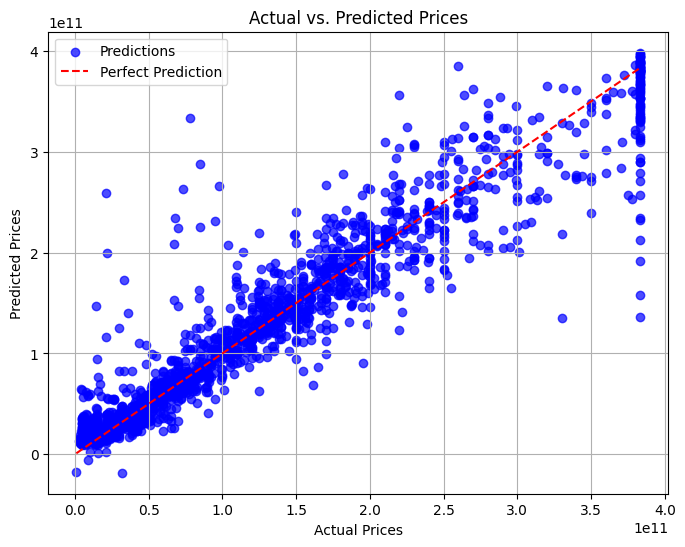

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb_best, alpha=0.7, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!nvidia-smi

Sat Feb 22 13:32:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Using Python 3.11.11 environment at: /usr
Resolved 2 packages in 117ms
Prepared 2 packages in 24ms
Installed 2 packages in 1ms
 + nvidia-ml-py==12.570.86
 + pynvml==12.0.0
Installing RAPIDS remaining 24.12.* libraries
Using Python 3.11.11 environment at: /usr
Resolved 154 packages in 1.25s
 Downloaded ucx-py-cu12
 Downloaded dask
 Downloaded cuspatial-cu12
 Downloaded libcuspatial-cu12
 Downloaded datashader
 Downloaded libucx-cu12
 Downloaded cucim-cu12
 Downloaded scikit-image
 Downloaded raft-dask-cu12
 Downloaded cuml-cu12
 Downloaded cugraph-cu12
 Downloaded cuvs-cu12
Prepared 30 packages in 39.58s
Uninstalled 3 packages in 43ms
Installed 30 packages in 123ms
 + cucim-cu12==24.12.0
 + cugraph-cu12==24.12.0
 + cuml-cu12==24.12.0
 + cuproj-cu12==24.12.0
 + cuspatial-cu12==24.12.0
 + cuvs-cu12==24.12.0
 + cuxfilter-cu12==24.12.0
 - dask==2024.10.0
 + dask==2024.11.2
 + dask-cuda==24.12.0
 + das

In [ ]:
import cuml
print(cuml.__version__)

24.12.00
